In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from functools import reduce

from functions_file import *
print(testfunction(4))

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
import statsmodels.api as sm
import seaborn as sn
import itertools
import collections        
from matplotlib import colors

from NNet import *
from scipy.stats import linregress
import copy
import time
from random import randrange

16


## Model-based Approach

### 1. Load Data

All columns:

    ['polygon','DOW','times','exp_id','lanes','direction',
    'busstops','seplane','complexity','length','road_rank',
    'v_Bus', 'k_Bus', 'q_Bus', # Taxi, Motorcycle, Heavy Vehicle, Medium Vehicle, Car
    'v_Car0020','k_Car0020', 'q_Car0020'] # e.g. 0020 = 2%

In [2]:
# speed_threshold = 1 #km/h
min_mean_speed = 15 #km/h
# min_diff_between_timestamps = '3s' #has to be a string
min_duration_of_stops = 5 #seconds

In [12]:
def calc_mean_qk(g1):
    q_m,k_m,v_t_m, v_m = [0,0,0,0]
    for i in g1:
        q_m += i[0]
        k_m += i[1]
        v_t_m += i[2]
        v_m += i[3]
    dev = len(g1)    
    return ["{:.3f}".format(q_m/dev),
            "{:.3f}".format(k_m/dev),
            "{:.3f}".format(v_t_m/dev),
            "{:.3f}".format(v_m/dev)]

def calc_mean_sl(g1):
    s_m,l_m = [0,0]
    for i in g1:
        s_m += i[0]
        l_m += i[1]
    dev = len(g1)    
    return ["{:.3f}".format(s_m/dev),
            "{:.3f}".format(l_m/dev)]

def calc_mean_all(g1):
    q_m, k_m, s_m,l_m = [0,0,0,0]
    for i in g1:
        q_m += i[0]
        k_m += i[1]
        s_m += i[2]
        l_m += i[3]
    dev = len(g1)    
    return ["{:.3f}".format(q_m/dev),
            "{:.3f}".format(k_m/dev),
            "{:.3f}".format(s_m/dev),
            "{:.3f}".format(l_m/dev)]


def calc_mean_all_with_speed(g1):
    q_m, k_m, s_m,l_m, v_origin_m, v_target_m = [0,0,0,0,0,0]
    for i in g1:
        q_m += i[0]
        k_m += i[1]
        s_m += i[2]
        l_m += i[3]
        v_origin_m += i[4]
        v_target_m += i[5]
    dev = len(g1)    
    return ["{:.3f}".format(q_m/dev),
            "{:.3f}".format(k_m/dev),
            "{:.3f}".format(s_m/dev),
            "{:.3f}".format(l_m/dev),
            "{:.3f}".format(v_origin_m/dev),
            "{:.3f}".format(v_target_m/dev)]

In [13]:
method = 'NNFD_w_events_one_stage'
numruns = 20 # 20
one_NNFD = pd.read_pickle('../output/result_runs_w_events/%s_%s_runs.pkl'%(method,numruns))

method = 'NNFD_w_events_two_stage'
numruns = 20 # 20
two_NNFD_first = pd.read_pickle('../output/result_runs_w_events/%s_%s_runs_first_stage_qkvtv.pkl'%(method,numruns))
two_NNFD_second = pd.read_pickle('../output/result_runs_w_events/%s_%s_runs_second_stage_sl.pkl'%(method,numruns))

method = 'NN_w_events'
numruns = 20 # 20
one_NN = pd.read_pickle('../output/result_runs_w_events/%s_%s_runs.pkl'%(method,numruns))

method = 'NN_w_events_two_stage'
numruns = 20 # 20
two_NN_first = pd.read_pickle('../output/result_runs_w_events/%s_%s_runs_first_stage_qkvtv.pkl'%(method,numruns))
two_NN_second = pd.read_pickle('../output/result_runs_w_events/%s_%s_runs_second_stage_sl.pkl'%(method,numruns))

method = 'NN_only_events'
numruns = 20 # 20
only_events_NN = pd.read_pickle('../output/result_runs_w_events/%s_%s_runs.pkl'%(method,numruns))


In [14]:
one_NNFD.Cols[0]

['q_all_MS',
 'k_all_MS',
 'stop_count',
 'lane_changes',
 'v_all_MS_Target',
 'v_all_MS_Orig']

In [15]:
#relevant scenario with one stage nnfd, including speeeds
ot = one_NNFD[one_NNFD.Pol=='total']
one_NNFD_r2 = ot.groupby('Scenario')['R2'].apply(lambda x: calc_mean_all_with_speed(x))
one_NNFD_r2n = ot.groupby('Scenario')['R2_n'].apply(lambda x: calc_mean_all_with_speed(x))
one_NNFD_mape = ot.groupby('Scenario')['MAPE'].apply(lambda x: calc_mean_all_with_speed(x))
display(one_NNFD_r2)
display(one_NNFD_r2n)
display(one_NNFD_mape)

Scenario
Scen0_qk     [0.811, 0.786, 0.590, 0.567, 0.764, 0.784]
Scen10_qk    [0.813, 0.798, 0.611, 0.579, 0.813, 0.833]
Scen11_qk    [0.847, 0.859, 0.807, 0.607, 0.832, 0.853]
Scen1_qk     [0.844, 0.858, 0.742, 0.590, 0.851, 0.872]
Scen3_qk     [0.816, 0.796, 0.665, 0.586, 0.728, 0.746]
Name: R2, dtype: object

Scenario
Scen0_qk     [0.785, 0.778, 0.579, 0.561, 0.509, 0.565]
Scen10_qk    [0.795, 0.793, 0.600, 0.569, 0.785, 0.815]
Scen11_qk    [0.832, 0.855, 0.796, 0.589, 0.783, 0.821]
Scen1_qk     [0.828, 0.854, 0.726, 0.569, 0.821, 0.858]
Scen3_qk     [0.795, 0.791, 0.651, 0.572, 0.538, 0.589]
Name: R2_n, dtype: object

Scenario
Scen0_qk     [0.169, 0.184, 0.602, 0.432, 0.208, 0.194]
Scen10_qk    [0.164, 0.175, 0.597, 0.428, 0.200, 0.190]
Scen11_qk    [0.166, 0.165, 0.447, 0.419, 0.185, 0.171]
Scen1_qk     [0.158, 0.162, 0.479, 0.428, 0.185, 0.170]
Scen3_qk     [0.163, 0.182, 0.543, 0.424, 0.209, 0.197]
Name: MAPE, dtype: object

In [17]:
#irrelevant scenario with one stage, only nn, including speeeds
ot3 = one_NN[one_NN.Pol=='total']
one_NN_r2 = ot3.groupby('Scenario')['R2'].apply(lambda x: calc_mean_all_with_speed(x))
one_NN_r2n = ot3.groupby('Scenario')['R2_n'].apply(lambda x: calc_mean_all_with_speed(x))
one_NN_mape = ot3.groupby('Scenario')['MAPE'].apply(lambda x: calc_mean_all_with_speed(x))
one_NN_mae = ot3.groupby('Scenario')['MAE'].apply(lambda x: calc_mean_all_with_speed(x))

display(one_NN_r2)
display(one_NN_r2n)
display(one_NN_mape)
display(one_NN_mae)

Scenario
Scen0_qk     [0.817, 0.778, 0.594, 0.560, 0.819, 0.838]
Scen10_qk    [0.813, 0.792, 0.614, 0.571, 0.826, 0.843]
Scen11_qk    [0.847, 0.865, 0.815, 0.601, 0.842, 0.861]
Scen1_qk     [0.843, 0.860, 0.751, 0.587, 0.819, 0.837]
Scen3_qk     [0.799, 0.791, 0.664, 0.586, 0.723, 0.741]
Name: R2, dtype: object

Scenario
Scen0_qk       [0.791, 0.770, 0.588, 0.548, 0.770, 0.805]
Scen10_qk      [0.780, 0.782, 0.601, 0.559, 0.781, 0.813]
Scen11_qk      [0.827, 0.857, 0.803, 0.580, 0.800, 0.833]
Scen1_qk       [0.822, 0.849, 0.739, 0.563, 0.657, 0.702]
Scen3_qk     [0.769, 0.778, 0.650, 0.566, -2.382, -2.076]
Name: R2_n, dtype: object

Scenario
Scen0_qk     [0.163, 0.184, 0.607, 0.456, 0.207, 0.195]
Scen10_qk    [0.176, 0.190, 0.596, 0.446, 0.208, 0.197]
Scen11_qk    [0.166, 0.169, 0.446, 0.419, 0.179, 0.167]
Scen1_qk     [0.164, 0.167, 0.483, 0.425, 0.184, 0.171]
Scen3_qk     [0.181, 0.190, 0.549, 0.433, 0.219, 0.207]
Name: MAPE, dtype: object

Scenario
Scen0_qk     [230.576, 16.646, 1.284, 4.029, 3.401, 3.257]
Scen10_qk    [248.380, 16.880, 1.318, 4.031, 3.450, 3.307]
Scen11_qk    [228.232, 14.696, 1.014, 3.894, 3.016, 2.843]
Scen1_qk     [229.674, 14.988, 1.119, 3.912, 3.102, 2.936]
Scen3_qk     [250.907, 17.140, 1.229, 3.944, 3.707, 3.576]
Name: MAE, dtype: object

In [26]:
one_stage_results = {#'r2d_NN':one_NN_r2,
                     #'r2n_NN':one_NN_r2n,
                     #'map_NN':one_NN_mape,
                     'r2d_NNFD':one_NNFD_r2,
                     'r2n_NNFD':one_NNFD_r2n,
                     'map_NNFD':one_NNFD_mape, 'mae_NNFD':one_NN_mae}

def process_one_stage(one_stage_results, assess_method):
    one_stage = []
    labels_one = []
    for key,val in one_stage_results.items():
        if (key[:3]==assess_method):
            temp = pd.DataFrame(val)
            temp[['q','k','stop','lc','v_tar','v_ori']] = pd.DataFrame(temp[temp.columns[0]].tolist(), index= temp.index) 
            one_stage.append(temp)
            labels_one.append(key)   
    return one_stage, labels_one

scenario_names = ['Scenario 1','Scenario 2', 'Scenario 5','Scenario 3','Scenario 4']

def plot_metrics(stages, labels, column = 'q', name = 'flow'):
    fig, ax = plt.subplots(1,figsize=(8, 5),dpi=200)
    ax.ticklabel_format(style = 'plain')
    #ax.set_title("A - Share of vehicle types",fontsize=15)
    for rdf in stages:
        rdf['scen_names'] = scenario_names
        temp = rdf.sort_values(by='scen_names')
        ax.scatter(range(len(temp)),temp[column].astype(float), label = '%s %s'%(name,column))
    ax.set_ylabel("R2 value of %s"%name, fontsize=15)
    #ax.set_xlabel("Number of lane changes per vehicle\n[-]", fontsize=15)
    plt.xticks(range(len(temp)),scenario_names,fontsize=12)
    plt.yticks(fontsize=12)
    ax.set_ylim([0.5,1])
    plt.legend()
    xlab = ''
    for i in temp.scen_names:
        xlab += str(i)+' - '
    #plt.xlabel(xlab)
    #plt.ylabel(rdf.columns[0] + '_' + column)
    ax.grid()

column_names = {'q':'Flow $q$', 'k': 'Density $k$', 'lc':'Lane changes',
             'stop':'Stops', 'v_tar':'Original speed','v_ori':'Target speed'} #wrong assigning of v_tar and v_orig in NN files
    
def plot_metrics_all_param(stages, labels, columns = ['q','k'],y_val = r'$R^{2}$', y_lim = [0,1] ):
    fig, ax = plt.subplots(1,figsize=(8, 5),dpi=150)
    ax.ticklabel_format(style = 'plain')
    #ax.set_title("A - Share of vehicle types",fontsize=15)
    save_name = ''
    for rdf in stages:
        for column in columns:
            save_name += column
            rdf['scen_names'] = scenario_names
            print(rdf)
            temp = rdf.sort_values(by='scen_names')
            print(temp)
            ax.scatter(range(len(temp)),temp[column].astype(float),marker = 'x', label = '%s'%(column_names[column]))
    ax.set_ylabel(y_val, fontsize=15)
    plt.xticks(range(len(temp)),temp['scen_names'],fontsize=12)
    plt.yticks(fontsize=12)
    ax.set_ylim(y_lim)
    plt.legend()
    xlab = ''
    for i in temp.scen_names:
        xlab += str(i)+' - '
    #plt.xlabel(xlab)
    #plt.ylabel(rdf.columns[0] + '_' + column)
    ax.grid()
    fig.savefig('%s_%s.png'%(y_val,save_name), dpi=200)


#%Loop -> 0 %Loop FCD-Auto -> 10 %Loop FCD-Auto 5% Taxi -> 1 %Loop FCD-Auto Bus -> 3 %Loop FCD-Auto 5% Taxi Bus ->11

                                                 R2_n      q      k   stop  \
Scenario                                                                     
Scen0_qk   [0.785, 0.778, 0.579, 0.561, 0.509, 0.565]  0.785  0.778  0.579   
Scen10_qk  [0.795, 0.793, 0.600, 0.569, 0.785, 0.815]  0.795  0.793  0.600   
Scen11_qk  [0.832, 0.855, 0.796, 0.589, 0.783, 0.821]  0.832  0.855  0.796   
Scen1_qk   [0.828, 0.854, 0.726, 0.569, 0.821, 0.858]  0.828  0.854  0.726   
Scen3_qk   [0.795, 0.791, 0.651, 0.572, 0.538, 0.589]  0.795  0.791  0.651   

              lc  v_tar  v_ori  scen_names  
Scenario                                    
Scen0_qk   0.561  0.509  0.565  Scenario 1  
Scen10_qk  0.569  0.785  0.815  Scenario 2  
Scen11_qk  0.589  0.783  0.821  Scenario 5  
Scen1_qk   0.569  0.821  0.858  Scenario 3  
Scen3_qk   0.572  0.538  0.589  Scenario 4  
                                                 R2_n      q      k   stop  \
Scenario                                                    

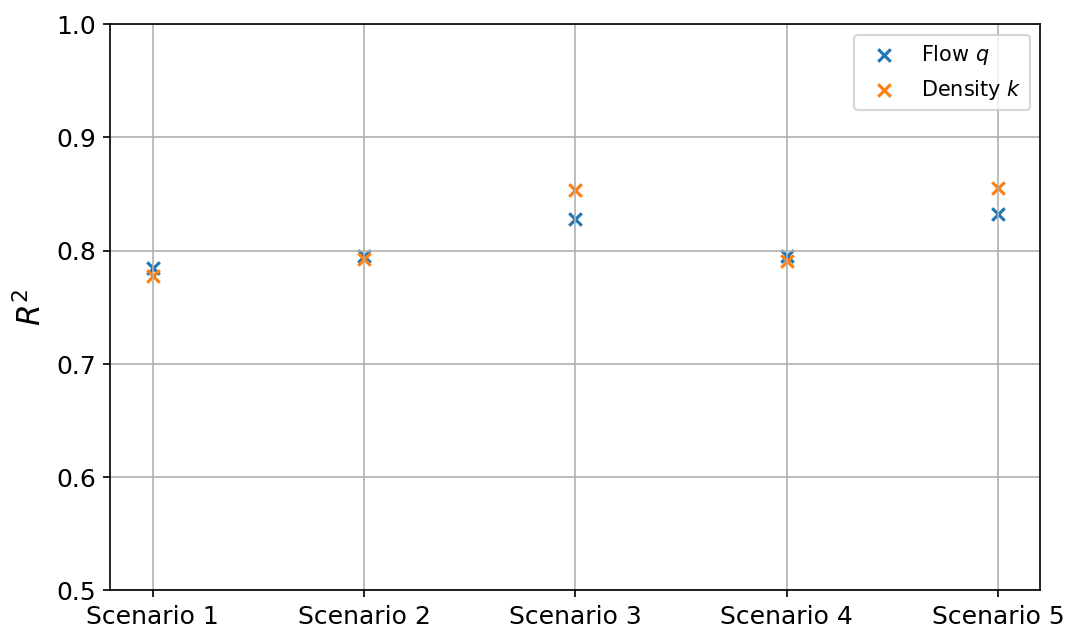

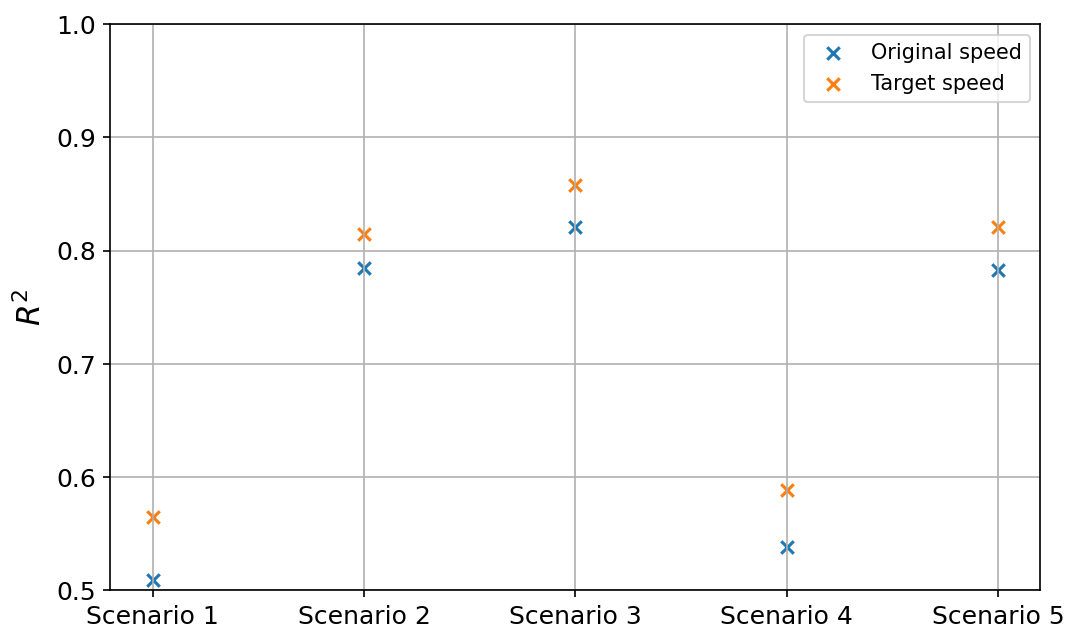

In [27]:
one_stage_r2d, one_stage_r2d_l = process_one_stage(one_stage_results,'r2n')
#ts_r2d_e,ts_r2d_e,ts_r2d_f_l,ts_r2d_s_l = process_two_stage(two_stage_results,'r2d')
plot_metrics_all_param(one_stage_r2d,one_stage_r2d_l,y_lim=[0.5,1])
plot_metrics_all_param(one_stage_r2d,one_stage_r2d_l,['v_tar','v_ori'],y_lim=[0.5,1])

                                                 MAPE      q      k   stop  \
Scenario                                                                     
Scen0_qk   [0.169, 0.184, 0.602, 0.432, 0.208, 0.194]  0.169  0.184  0.602   
Scen10_qk  [0.164, 0.175, 0.597, 0.428, 0.200, 0.190]  0.164  0.175  0.597   
Scen11_qk  [0.166, 0.165, 0.447, 0.419, 0.185, 0.171]  0.166  0.165  0.447   
Scen1_qk   [0.158, 0.162, 0.479, 0.428, 0.185, 0.170]  0.158  0.162  0.479   
Scen3_qk   [0.163, 0.182, 0.543, 0.424, 0.209, 0.197]  0.163  0.182  0.543   

              lc  v_tar  v_ori  scen_names  
Scenario                                    
Scen0_qk   0.432  0.208  0.194  Scenario 1  
Scen10_qk  0.428  0.200  0.190  Scenario 2  
Scen11_qk  0.419  0.185  0.171  Scenario 5  
Scen1_qk   0.428  0.185  0.170  Scenario 3  
Scen3_qk   0.424  0.209  0.197  Scenario 4  
                                                 MAPE      q      k   stop  \
Scenario                                                    

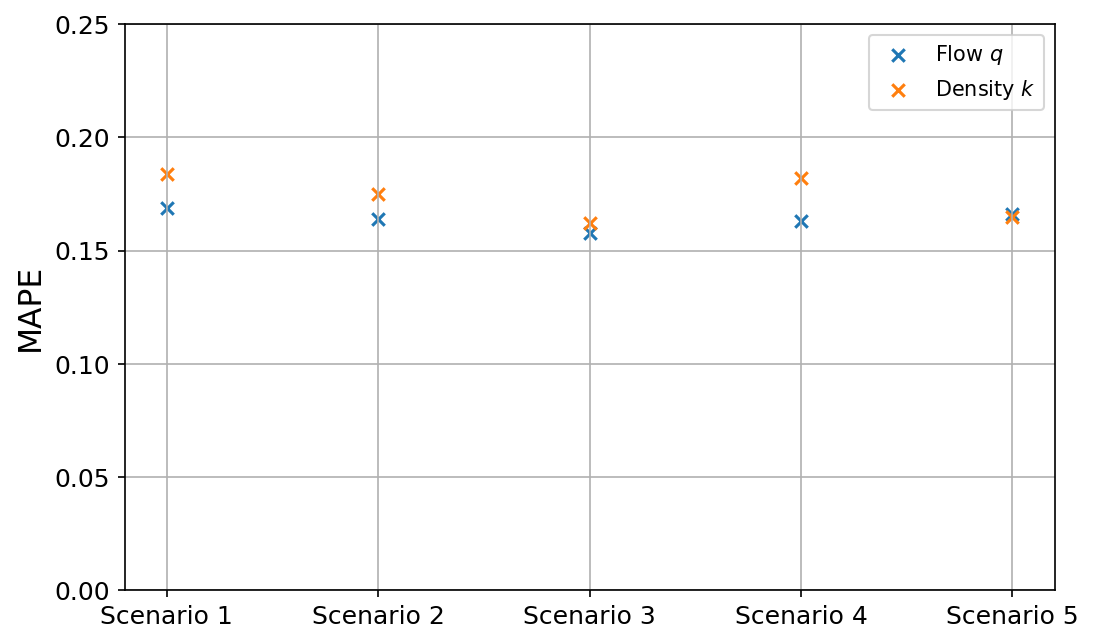

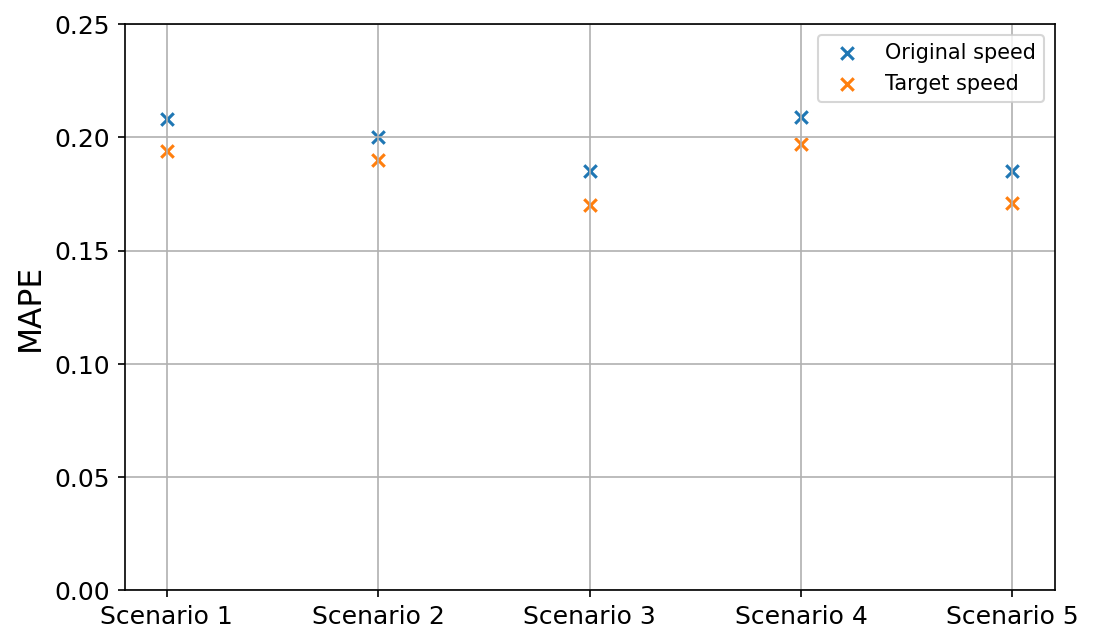

In [28]:
one_stage_r2d, one_stage_r2d_l = process_one_stage(one_stage_results,'map')
plot_metrics_all_param(one_stage_r2d,one_stage_r2d_l,['q','k'],'MAPE',y_lim = [0,0.25])
plot_metrics_all_param(one_stage_r2d,one_stage_r2d_l,['v_tar','v_ori'],'MAPE',y_lim = [0,0.25])

                                                 R2_n      q      k   stop  \
Scenario                                                                     
Scen0_qk   [0.785, 0.778, 0.579, 0.561, 0.509, 0.565]  0.785  0.778  0.579   
Scen10_qk  [0.795, 0.793, 0.600, 0.569, 0.785, 0.815]  0.795  0.793  0.600   
Scen11_qk  [0.832, 0.855, 0.796, 0.589, 0.783, 0.821]  0.832  0.855  0.796   
Scen1_qk   [0.828, 0.854, 0.726, 0.569, 0.821, 0.858]  0.828  0.854  0.726   
Scen3_qk   [0.795, 0.791, 0.651, 0.572, 0.538, 0.589]  0.795  0.791  0.651   

              lc  v_tar  v_ori  scen_names  
Scenario                                    
Scen0_qk   0.561  0.509  0.565  Scenario 1  
Scen10_qk  0.569  0.785  0.815  Scenario 2  
Scen11_qk  0.589  0.783  0.821  Scenario 5  
Scen1_qk   0.569  0.821  0.858  Scenario 3  
Scen3_qk   0.572  0.538  0.589  Scenario 4  
                                                 R2_n      q      k   stop  \
Scenario                                                    

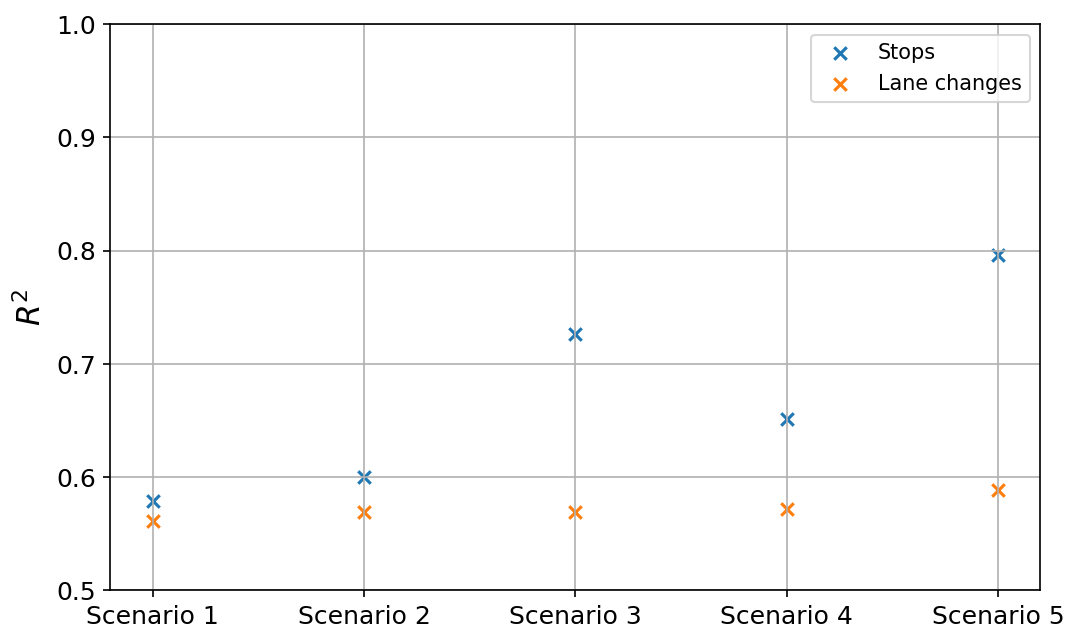

In [29]:
one_stage_r2d, one_stage_r2d_l = process_one_stage(one_stage_results,'r2n')
plot_metrics_all_param(one_stage_r2d,one_stage_r2d_l,['stop','lc'],y_lim=[0.5,1])
#plot_metrics_all_param(one_stage_r2d,one_stage_r2d_l,['stop','lc'],y_lim=[0.5,1])

                                                     MAE        q       k  \
Scenario                                                                    
Scen0_qk   [230.576, 16.646, 1.284, 4.029, 3.401, 3.257]  230.576  16.646   
Scen10_qk  [248.380, 16.880, 1.318, 4.031, 3.450, 3.307]  248.380  16.880   
Scen11_qk  [228.232, 14.696, 1.014, 3.894, 3.016, 2.843]  228.232  14.696   
Scen1_qk   [229.674, 14.988, 1.119, 3.912, 3.102, 2.936]  229.674  14.988   
Scen3_qk   [250.907, 17.140, 1.229, 3.944, 3.707, 3.576]  250.907  17.140   

            stop     lc  v_tar  v_ori  scen_names  
Scenario                                           
Scen0_qk   1.284  4.029  3.401  3.257  Scenario 1  
Scen10_qk  1.318  4.031  3.450  3.307  Scenario 2  
Scen11_qk  1.014  3.894  3.016  2.843  Scenario 5  
Scen1_qk   1.119  3.912  3.102  2.936  Scenario 3  
Scen3_qk   1.229  3.944  3.707  3.576  Scenario 4  
                                                     MAE        q       k  \
Scenario           

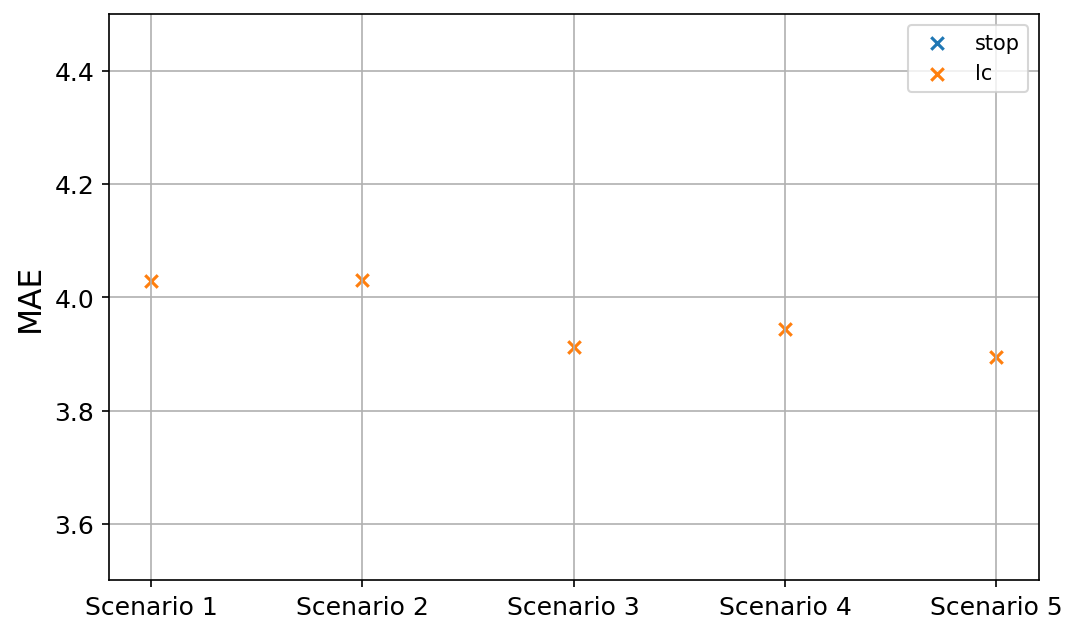

In [15]:
one_stage_r2d, one_stage_r2d_l = process_one_stage(one_stage_results,'mae')
plot_metrics_all_param(one_stage_r2d,one_stage_r2d_l,['stop','lc'],'MAE',y_lim=[3.5,4.5])

In [51]:
one_stage_r2d

[                                                   R2      q      k   stop  \
 Scenario                                                                     
 Scen0_qk   [0.817, 0.778, 0.594, 0.560, 0.819, 0.838]  0.817  0.778  0.594   
 Scen10_qk  [0.813, 0.792, 0.614, 0.571, 0.826, 0.843]  0.813  0.792  0.614   
 Scen11_qk  [0.847, 0.865, 0.815, 0.601, 0.842, 0.861]  0.847  0.865  0.815   
 Scen1_qk   [0.843, 0.860, 0.751, 0.587, 0.819, 0.837]  0.843  0.860  0.751   
 Scen3_qk   [0.799, 0.791, 0.664, 0.586, 0.723, 0.741]  0.799  0.791  0.664   
 
               lc  v_tar  v_ori  
 Scenario                        
 Scen0_qk   0.560  0.819  0.838  
 Scen10_qk  0.571  0.826  0.843  
 Scen11_qk  0.601  0.842  0.861  
 Scen1_qk   0.587  0.819  0.837  
 Scen3_qk   0.586  0.723  0.741  ,
                                                    R2      q      k   stop  \
 Scenario                                                                     
 Scen0_qk   [0.811, 0.786, 0.590, 0.567, 0.764, 

# further calculations

In [6]:
ot2_first = two_NNFD_first[two_NNFD_first.Pol == 'total']
ot2_sec = two_NNFD_second[two_NNFD_second.Pol == 'total']
two_NNFD_r2_f = ot2_first.groupby('Scenario')['R2'].apply(lambda x: calc_mean_qk(x))
two_NNFD_r2n_f = ot2_first.groupby('Scenario')['R2_n'].apply(lambda x: calc_mean_qk(x))
two_NNFD_mape_f = ot2_first.groupby('Scenario')['MAPE'].apply(lambda x: calc_mean_qk(x))

two_NNFD_r2_s = ot2_sec.groupby('Scenario')['R2'].apply(lambda x: calc_mean_sl(x))
two_NNFD_r2n_s = ot2_sec.groupby('Scenario')['R2_n'].apply(lambda x: calc_mean_sl(x))
two_NNFD_mape_s = ot2_sec.groupby('Scenario')['MAPE'].apply(lambda x: calc_mean_sl(x))
display(two_NNFD_r2_f)
display(two_NNFD_r2n_f)
display(two_NNFD_mape_f)
display(two_NNFD_r2_s)
display(two_NNFD_r2n_s)
display(two_NNFD_mape_s)

Scenario
Scen0_qk     [0.844, 0.791, 0.860, 0.883]
Scen10_qk    [0.860, 0.800, 0.873, 0.896]
Scen11_qk    [0.907, 0.894, 0.792, 0.810]
Scen1_qk     [0.915, 0.896, 0.815, 0.837]
Scen3_qk     [0.861, 0.827, 0.852, 0.873]
Name: R2, dtype: object

Scenario
Scen0_qk       [0.829, 0.783, 0.836, 0.867]
Scen10_qk      [0.848, 0.788, 0.852, 0.882]
Scen11_qk    [0.903, 0.886, -1.089, -0.860]
Scen1_qk       [0.911, 0.890, 0.437, 0.506]
Scen3_qk       [0.850, 0.817, 0.815, 0.851]
Name: R2_n, dtype: object

Scenario
Scen0_qk     [0.140, 0.171, 0.188, 0.172]
Scen10_qk    [0.134, 0.169, 0.180, 0.161]
Scen11_qk    [0.125, 0.137, 0.163, 0.141]
Scen1_qk     [0.118, 0.140, 0.153, 0.128]
Scen3_qk     [0.140, 0.162, 0.177, 0.158]
Name: MAPE, dtype: object

Scenario
Scen0_qk     [0.585, 0.577]
Scen10_qk    [0.611, 0.590]
Scen11_qk    [0.773, 0.572]
Scen1_qk     [0.668, 0.549]
Scen3_qk     [0.674, 0.593]
Name: R2, dtype: object

Scenario
Scen0_qk       [0.574, 0.560]
Scen10_qk      [0.602, 0.580]
Scen11_qk      [0.743, 0.525]
Scen1_qk     [-5.327, -2.660]
Scen3_qk       [0.654, 0.580]
Name: R2_n, dtype: object

Scenario
Scen0_qk     [0.582, 0.414]
Scen10_qk    [0.575, 0.403]
Scen11_qk    [0.440, 0.422]
Scen1_qk     [0.482, 0.470]
Scen3_qk     [0.549, 0.409]
Name: MAPE, dtype: object

In [7]:
ot3 = one_NN[one_NN.Pol=='total']
one_NN_r2 = ot3.groupby('Scenario')['R2'].apply(lambda x: calc_mean_all(x))
one_NN_r2n = ot3.groupby('Scenario')['R2_n'].apply(lambda x: calc_mean_all(x))
one_NN_mape = ot3.groupby('Scenario')['MAPE'].apply(lambda x: calc_mean_all(x))
display(one_NN_r2)
display(one_NN_r2n)
display(one_NN_mape)

Scenario
Scen0_qk     [0.817, 0.778, 0.594, 0.560]
Scen10_qk    [0.813, 0.792, 0.614, 0.571]
Scen11_qk    [0.847, 0.865, 0.815, 0.601]
Scen1_qk     [0.843, 0.860, 0.751, 0.587]
Scen3_qk     [0.799, 0.791, 0.664, 0.586]
Name: R2, dtype: object

Scenario
Scen0_qk     [0.791, 0.770, 0.588, 0.548]
Scen10_qk    [0.780, 0.782, 0.601, 0.559]
Scen11_qk    [0.827, 0.857, 0.803, 0.580]
Scen1_qk     [0.822, 0.849, 0.739, 0.563]
Scen3_qk     [0.769, 0.778, 0.650, 0.566]
Name: R2_n, dtype: object

Scenario
Scen0_qk     [0.163, 0.184, 0.607, 0.456]
Scen10_qk    [0.176, 0.190, 0.596, 0.446]
Scen11_qk    [0.166, 0.169, 0.446, 0.419]
Scen1_qk     [0.164, 0.167, 0.483, 0.425]
Scen3_qk     [0.181, 0.190, 0.549, 0.433]
Name: MAPE, dtype: object

In [8]:
ot4_first = two_NN_first[two_NN_first.Pol == 'total']
ot4_sec = two_NN_second[two_NN_second.Pol == 'total']

two_NN_r2_f = ot4_first.groupby('Scenario')['R2'].apply(lambda x: calc_mean_qk(x))
two_NN_r2n_f = ot4_first.groupby('Scenario')['R2_n'].apply(lambda x: calc_mean_qk(x))
two_NN_mape_f = ot4_first.groupby('Scenario')['MAPE'].apply(lambda x: calc_mean_qk(x))

two_NN_r2_s = ot4_sec.groupby('Scenario')['R2'].apply(lambda x: calc_mean_sl(x))
two_NN_r2n_s = ot4_sec.groupby('Scenario')['R2_n'].apply(lambda x: calc_mean_sl(x))
two_NN_mape_s = ot4_sec.groupby('Scenario')['MAPE'].apply(lambda x: calc_mean_sl(x))

display(two_NN_r2_f)
display(two_NN_r2n_f)
display(two_NN_mape_f)
display(two_NN_r2_s)
display(two_NN_r2n_s)
display(two_NN_mape_s)

Scenario
Scen0_qk     [0.850, 0.782, 0.847, 0.869]
Scen10_qk    [0.846, 0.808, 0.867, 0.890]
Scen11_qk    [0.906, 0.895, 0.813, 0.832]
Scen1_qk     [0.912, 0.897, 0.889, 0.911]
Scen3_qk     [0.873, 0.830, 0.849, 0.870]
Name: R2, dtype: object

Scenario
Scen0_qk     [0.832, 0.765, 0.822, 0.849]
Scen10_qk    [0.823, 0.800, 0.842, 0.877]
Scen11_qk    [0.902, 0.888, 0.494, 0.559]
Scen1_qk     [0.907, 0.889, 0.858, 0.892]
Scen3_qk     [0.861, 0.823, 0.794, 0.830]
Name: R2_n, dtype: object

Scenario
Scen0_qk     [0.143, 0.177, 0.184, 0.169]
Scen10_qk    [0.141, 0.163, 0.186, 0.167]
Scen11_qk    [0.118, 0.134, 0.158, 0.135]
Scen1_qk     [0.122, 0.143, 0.153, 0.130]
Scen3_qk     [0.135, 0.161, 0.176, 0.158]
Name: MAPE, dtype: object

Scenario
Scen0_qk     [0.573, 0.563]
Scen10_qk    [0.583, 0.578]
Scen11_qk    [0.796, 0.607]
Scen1_qk     [0.702, 0.572]
Scen3_qk     [0.669, 0.588]
Name: R2, dtype: object

Scenario
Scen0_qk     [0.346, 0.122]
Scen10_qk    [0.559, 0.564]
Scen11_qk    [0.780, 0.586]
Scen1_qk     [0.623, 0.514]
Scen3_qk     [0.652, 0.562]
Name: R2_n, dtype: object

Scenario
Scen0_qk     [0.639, 0.495]
Scen10_qk    [0.584, 0.422]
Scen11_qk    [0.456, 0.410]
Scen1_qk     [0.510, 0.420]
Scen3_qk     [0.546, 0.439]
Name: MAPE, dtype: object

In [9]:
ot5 = only_events_NN[only_events_NN.Pol=='total']
only_events_NN_r2 = ot5.groupby('Scenario')['R2'].apply(lambda x: calc_mean_sl(x))
only_events_NN_r2n = ot5.groupby('Scenario')['R2_n'].apply(lambda x: calc_mean_sl(x))
only_events_NN_mape = ot5.groupby('Scenario')['MAPE'].apply(lambda x: calc_mean_sl(x))
display(only_events_NN_r2)
display(only_events_NN_r2n)
display(only_events_NN_mape)

Scenario
Scen0_qk     [0.592, 0.566]
Scen10_qk    [0.606, 0.569]
Scen11_qk    [0.800, 0.605]
Scen1_qk     [0.754, 0.586]
Scen3_qk     [0.695, 0.586]
Name: R2, dtype: object

Scenario
Scen0_qk     [0.579, 0.559]
Scen10_qk    [0.594, 0.554]
Scen11_qk    [0.788, 0.584]
Scen1_qk     [0.737, 0.566]
Scen3_qk     [0.676, 0.565]
Name: R2_n, dtype: object

Scenario
Scen0_qk     [0.589, 0.432]
Scen10_qk    [0.598, 0.443]
Scen11_qk    [0.458, 0.416]
Scen1_qk     [0.479, 0.428]
Scen3_qk     [0.549, 0.440]
Name: MAPE, dtype: object

In [10]:
one_stage_results = {'r2d_NN':one_NN_r2,
                     'r2n_NN':one_NN_r2n,
                     'map_NN':one_NN_mape,
                     #'r2d_NN_e':only_events_NN_r2,
                     #'r2n_NN_e':only_events_NN_r2n,
                     #'map_NN_e':only_events_NN_mape,
                     'r2d_NNFD':one_NNFD_r2,
                     'r2n_NNFD':one_NNFD_r2n,
                     'map_NNFD':one_NNFD_mape,}

In [11]:
two_stage_results = {'r2d_NN___f':two_NN_r2_f,
                     'r2n_NN___f':two_NN_r2n_f,
                     'map_NN___f':two_NN_mape_f,
                     'r2d_NN___s':two_NN_r2_s,
                     'r2n_NN___s':two_NN_r2n_s,
                     'map_NN___s':two_NN_mape_s,
                     'r2d_NNFD_f':two_NNFD_r2_f,
                     'r2n_NNFD_f':two_NNFD_r2n_f,
                     'map_NNFD_f':two_NNFD_mape_f,
                     'r2d_NNFD_s':two_NNFD_r2_s,
                     'r2n_NNFD_s':two_NNFD_r2n_s,
                     'map_NNFD_s':two_NNFD_mape_s}

In [17]:
assess_method = 'r2d' #r2d (impl by V), r2n (r2_score), map (MAPE)

In [27]:
def process_one_stage(one_stage_results, assess_method):
    one_stage = []
    labels_one = []
    for key,val in one_stage_results.items():
        if (key[:3]==assess_method) and (key[-1]!='e'):
            temp = pd.DataFrame(val)
            temp[['q','k','stop','lc']] = pd.DataFrame(temp[temp.columns[0]].tolist(), index= temp.index)
            one_stage.append(temp)
            labels_one.append(key)   
    return one_stage, labels_one

def process_one_stage_events_only(one_stage_results, assess_method):
    one_stage = []
    labels_one = []
    for key,val in one_stage_results.items():
        if (key[:3]==assess_method) and (key[-1]=='e'):
            temp = pd.DataFrame(val)
            temp[['stop','lc']] = pd.DataFrame(temp[temp.columns[0]].tolist(), index= temp.index)
            one_stage.append(temp)
            labels_one.append(key)   
    return one_stage, labels_one

def process_two_stage(two_stage_results, assess_method):
    first_stage = []
    sec_stage = []
    labels_first = []
    labels_sec = []
    for key,val in two_stage_results.items():
        if key[:3]==assess_method:
            if key[-1] == 'f':
                temp = pd.DataFrame(val)
                x_label = temp.index
                temp[['q','k','v_real','v_target']] = pd.DataFrame(temp[temp.columns[0]].tolist(), index= temp.index)
                first_stage.append(temp)
                labels_first.append(key)
            else:
                temp = pd.DataFrame(val)
                temp[['stop','lc']] = pd.DataFrame(temp[temp.columns[0]].tolist(), index= temp.index)
                sec_stage.append(temp)
                labels_sec.append(key)     
    return first_stage, sec_stage, labels_first, labels_sec

def plot_metrics(stages, labels, column = 'q'):
    if len(stages)==3:
        plt.figure(figsize=(10, 10), dpi=80)
        for rdf in stages[0]:
            plt.scatter(range(len(rdf)),rdf[column].astype(float))
        for rdf in stages[1]:
            plt.scatter(range(len(rdf)),rdf[column].astype(float))
        for rdf in stages[2]:
            plt.scatter(range(len(rdf)),rdf[column].astype(float))
        plt.legend([labels[0]+labels[1]][0]+labels[2])
        xlab = ''
        for i in rdf.index:
            xlab += str(i)+' - '
        plt.xlabel(xlab)
        plt.ylabel(rdf.columns[0] + '_' + column)
    elif len(stages)==2:
        plt.figure(figsize=(10, 10), dpi=80)
        for rdf in stages[0]:
            plt.scatter(range(len(rdf)),rdf[column].astype(float))
        for rdf in stages[1]:
            plt.scatter(range(len(rdf)),rdf[column].astype(float))
        plt.legend([labels[0]+labels[1]][0])
        xlab = ''
        for i in rdf.index:
            xlab += str(i)+' - '
        plt.xlabel(xlab)
        plt.ylabel(rdf.columns[0] + '_' + column)
    else:
        plt.figure(figsize=(10, 10), dpi=80)
        for rdf in stages:
            plt.scatter(range(len(rdf)),rdf[column].astype(float))
        plt.legend(labels)
        xlab = ''
        for i in rdf.index:
            xlab += str(i)+' - '
        plt.xlabel(xlab)
        plt.ylabel(rdf.columns[0] + '_' + column)

Text(0, 0.5, 'R2_stop')

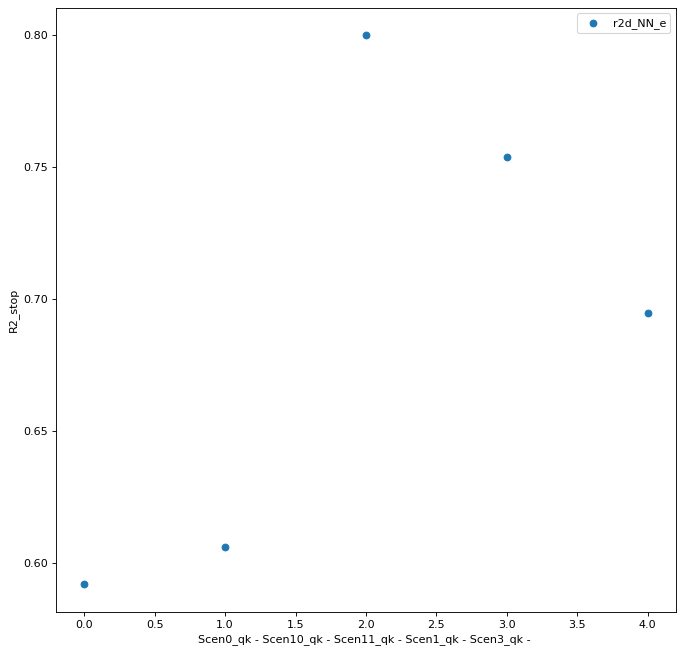

In [28]:
ose_r2d, ose_r2d_l = process_one_stage_events_only(one_stage_results,'r2d')
#ts_r2d_e,ts_r2d_e,ts_r2d_f_l,ts_r2d_s_l = process_two_stage(two_stage_results,'r2d')
plot_metrics([ose_r2d],[ose_r2d_l],'stop')
# Loop || Loop + 5% FCD || Loop + 5% FCD + Taxi + Bus || Loop + 5% FCD + Taxi || Loop + 5% FCD + Bus
# Red + Green: Two stage, so the first net trained without stops and lcs

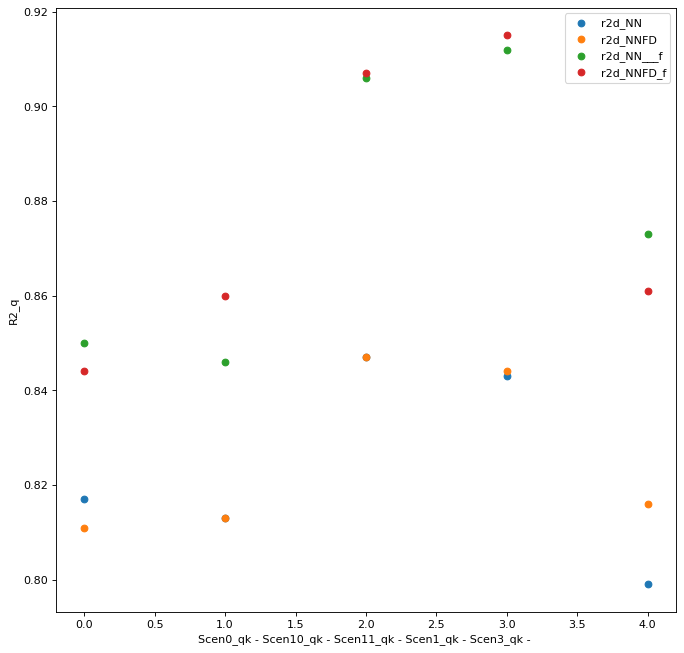

In [22]:
os_r2d, os_r2d_l = process_one_stage(one_stage_results,'r2d')
ts_r2d_f,ts_r2d_s,ts_r2d_f_l,ts_r2d_s_l = process_two_stage(two_stage_results,'r2d')
plot_metrics([os_r2d,ts_r2d_f],[os_r2d_l,ts_r2d_f_l])

# Loop || Loop + 5% FCD || Loop + 5% FCD + Taxi + Bus || Loop + 5% FCD + Taxi || Loop + 5% FCD + Bus
# Red + Green: Two stage, so the first net trained without stops and lcs

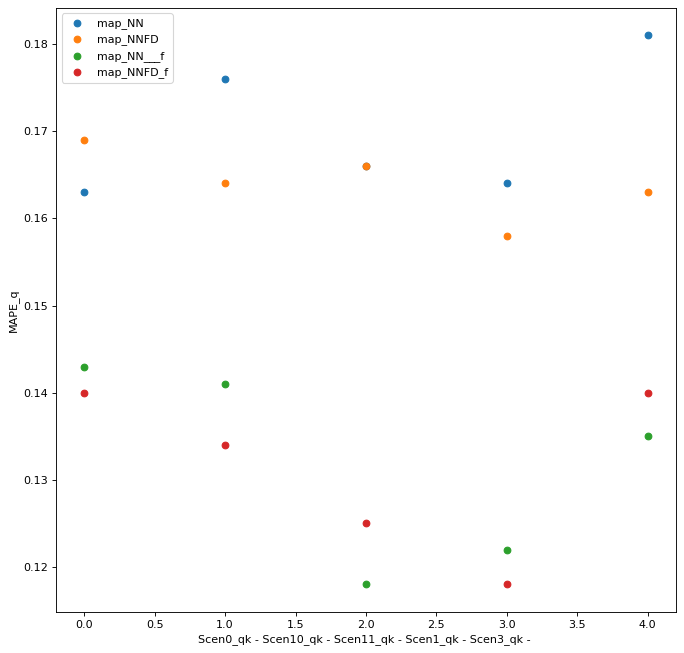

In [23]:
os_r2d, os_r2d_l = process_one_stage(one_stage_results,'map')
ts_r2d_f,ts_r2d_s,ts_r2d_f_l,ts_r2d_s_l = process_two_stage(two_stage_results,'map')
plot_metrics([os_r2d,ts_r2d_f],[os_r2d_l,ts_r2d_f_l])
# Loop || Loop + 5% FCD || Loop + 5% FCD + Taxi + Bus || Loop + 5% FCD + Taxi || Loop + 5% FCD + Bus
# Red + Green: Two stage, so the first net trained without stops and lcs

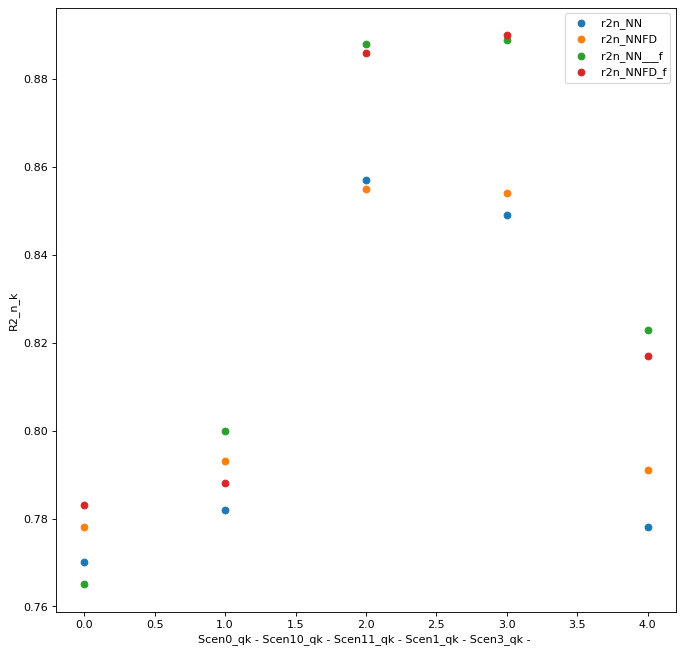

In [15]:
os_r2d, os_r2d_l = process_one_stage(one_stage_results,'r2n')
ts_r2d_f,ts_r2d_s,ts_r2d_f_l,ts_r2d_s_l = process_two_stage(two_stage_results,'r2n')
plot_metrics([os_r2d,ts_r2d_f],[os_r2d_l,ts_r2d_f_l],'k')

# Loop || Loop + 5% FCD || Loop + 5% FCD + Taxi + Bus || Loop + 5% FCD + Taxi || Loop + 5% FCD + Bus
# Red + Green: Two stage, so the first net trained without stops and lcs

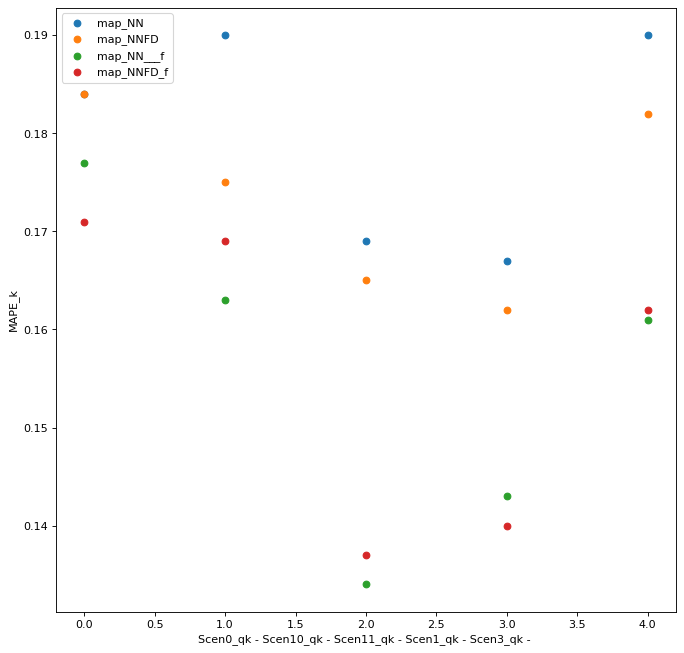

In [21]:
os_r2d, os_r2d_l = process_one_stage(one_stage_results,'map')
ts_r2d_f,ts_r2d_s,ts_r2d_f_l,ts_r2d_s_l = process_two_stage(two_stage_results,'map')
plot_metrics([os_r2d,ts_r2d_f],[os_r2d_l,ts_r2d_f_l],'k')
# Loop || Loop + 5% FCD || Loop + 5% FCD + Taxi + Bus || Loop + 5% FCD + Taxi || Loop + 5% FCD + Bus
# Red + Green: Two stage, so the first net trained without stops and lcs

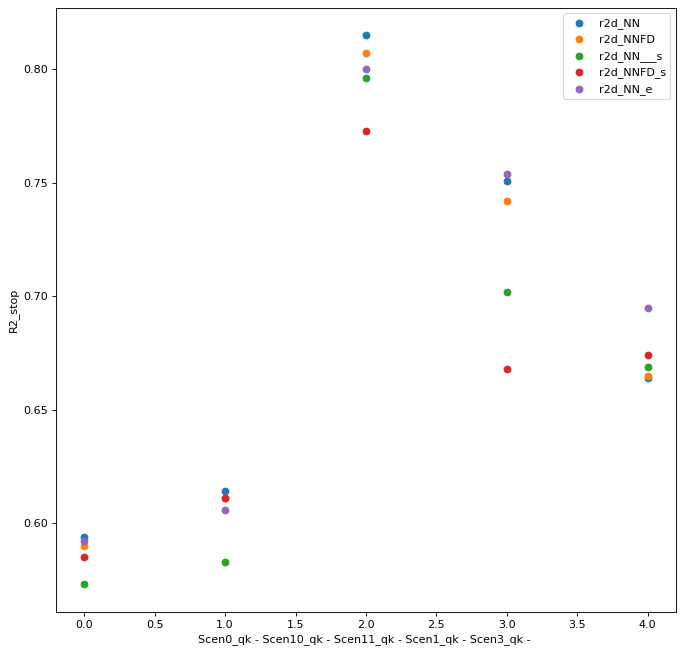

In [31]:
os_r2d, os_r2d_l = process_one_stage(one_stage_results,'r2d')
ts_r2d_f,ts_r2d_s,ts_r2d_f_l,ts_r2d_s_l = process_two_stage(two_stage_results,'r2d')
ose_r2d, ose_r2d_l = process_one_stage_events_only(one_stage_results,'r2d')
plot_metrics([os_r2d,ts_r2d_s,ose_r2d],[os_r2d_l,ts_r2d_s_l,ose_r2d_l],'stop')
# Loop || Loop + 5% FCD || Loop + 5% FCD + Taxi + Bus || Loop + 5% FCD + Taxi || Loop + 5% FCD + Bus
# Red + Green: Two stage, so the first net trained without stops and lcs

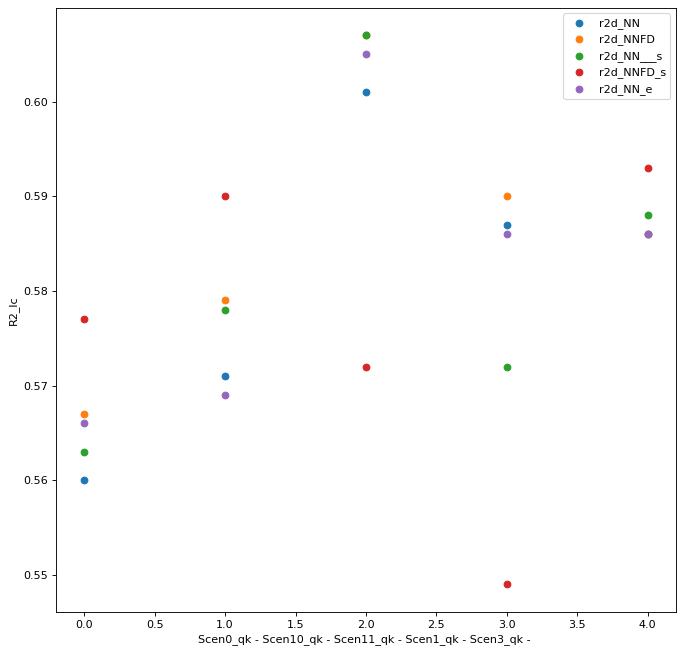

In [32]:
os_r2d, os_r2d_l = process_one_stage(one_stage_results,'r2d')
ts_r2d_f,ts_r2d_s,ts_r2d_f_l,ts_r2d_s_l = process_two_stage(two_stage_results,'r2d')
ose_r2d, ose_r2d_l = process_one_stage_events_only(one_stage_results,'r2d')
plot_metrics([os_r2d,ts_r2d_s,ose_r2d],[os_r2d_l,ts_r2d_s_l,ose_r2d_l],'lc')
# Loop || Loop + 5% FCD || Loop + 5% FCD + Taxi + Bus || Loop + 5% FCD + Taxi || Loop + 5% FCD + Bus
# Red + Green: Two stage, so the first net trained without stops and lcs

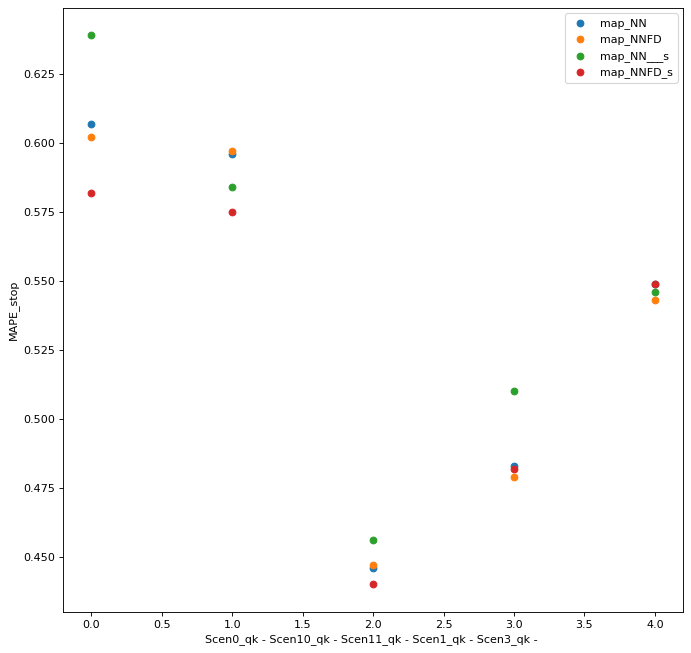

In [18]:
os_r2d, os_r2d_l = process_one_stage(one_stage_results,'map')
ts_r2d_f,ts_r2d_s,ts_r2d_f_l,ts_r2d_s_l = process_two_stage(two_stage_results,'map')
plot_metrics([os_r2d,ts_r2d_s],[os_r2d_l,ts_r2d_s_l],'stop')
# Loop || Loop + 5% FCD || Loop + 5% FCD + Taxi + Bus || Loop + 5% FCD + Taxi || Loop + 5% FCD + Bus
# Red + Green: Two stage, so the first net trained without stops and lcs

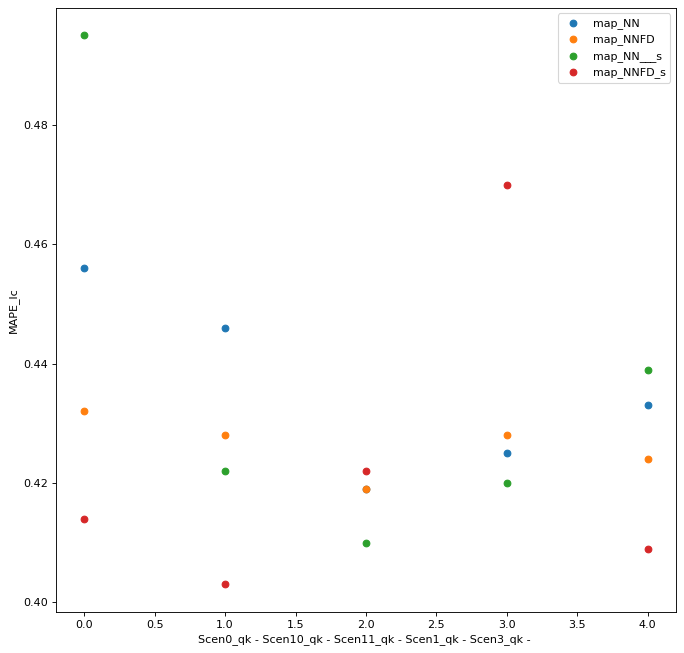

In [19]:
os_r2d, os_r2d_l = process_one_stage(one_stage_results,'map')
ts_r2d_f,ts_r2d_s,ts_r2d_f_l,ts_r2d_s_l = process_two_stage(two_stage_results,'map')
plot_metrics([os_r2d,ts_r2d_s],[os_r2d_l,ts_r2d_s_l],'lc')
# Loop || Loop + 5% FCD || Loop + 5% FCD + Taxi + Bus || Loop + 5% FCD + Taxi || Loop + 5% FCD + Bus
# Red + Green: Two stage, so the first net trained without stops and lcs